## Holder analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
df_contracts_bad = pd.read_csv('../csv_outputs/bad_tokens/master_contract.csv')
df_contracts_good = pd.read_csv('../csv_outputs/good_tokens/master_contract.csv')

df_holders_list_bad = pd.read_csv('../csv_outputs/bad_tokens/master_holders_list.csv')
df_holders_list_good = pd.read_csv('../csv_outputs/good_tokens/master_holders_list.csv')

df_holders_bad = pd.read_csv('../csv_outputs/bad_tokens/master_holders.csv')
df_holders_good = pd.read_csv('../csv_outputs/good_tokens/master_holders.csv')



## Distribution of number of total holders

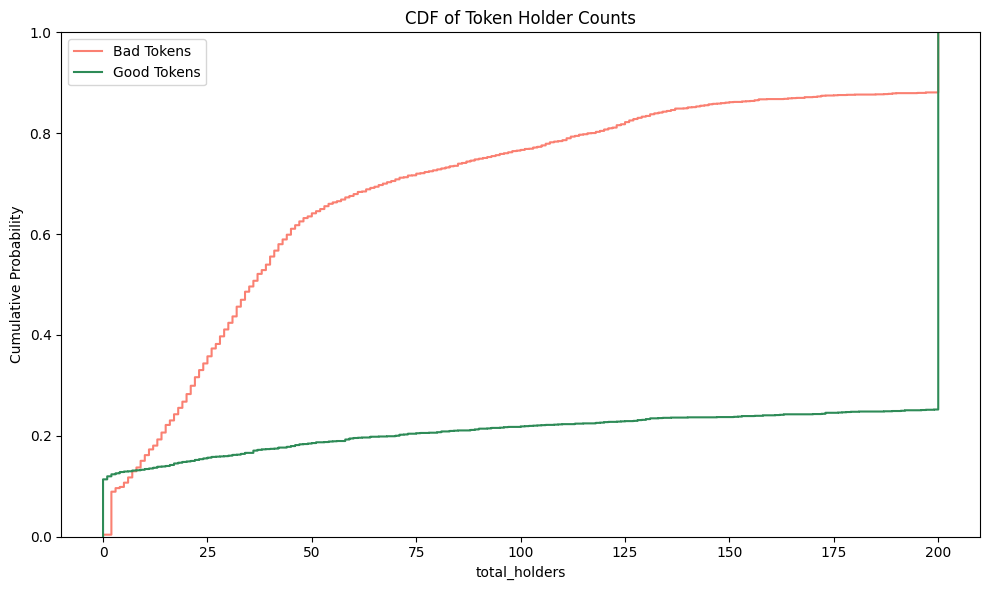

In [17]:
# Ensure numeric
df_holders_bad['total_holders'] = pd.to_numeric(df_holders_bad['total_holders'], errors='coerce')
df_holders_good['total_holders'] = pd.to_numeric(df_holders_good['total_holders'], errors='coerce')

# Drop NaNs
bad_holders = df_holders_bad['total_holders'].dropna()
good_holders = df_holders_good['total_holders'].dropna()

# Create single figure
plt.figure(figsize=(10, 6))

# Plot both CDFs
sns.ecdfplot(bad_holders, label='Bad Tokens', color='salmon')
sns.ecdfplot(good_holders, label='Good Tokens', color='seagreen')

# Add labels and legend
plt.title('CDF of Token Holder Counts')
plt.xlabel('total_holders')
plt.ylabel('Cumulative Probability')
plt.legend()

plt.tight_layout()
plt.show()

## Owner wallet contains \< 5% of the circulating token supply

/tmp/ipykernel_744418/855554641.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, x='Owner Category', y='Token Count', palette='Set2')


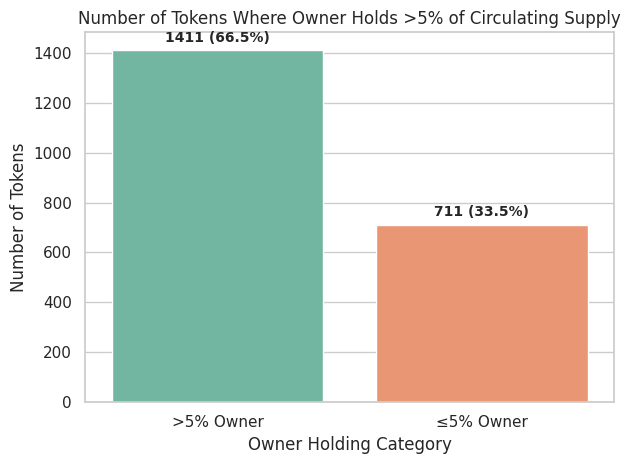

In [4]:
# Owner/creator wallet contains < 5% of circulating token supply

# Load data
df_contracts = pd.read_csv('../csv_outputs/master_contract.csv')
df_holders_list = pd.read_csv('../csv_outputs/master_holders_list.csv')
df_holders = pd.read_csv('../csv_outputs/master_holders.csv')  # has total_circulating_supply

# Merge holder list with contract info (to get owner)
df_merged = df_holders_list.merge(df_contracts[['token_address', 'owner']], on='token_address', how='left')

# Merge with circulating supply
df_merged = df_merged.merge(df_holders[['token_address', 'total_circulating_supply']], on='token_address', how='left')

# Normalize address case
df_merged['holder_address'] = df_merged['holder_address'].str.lower()
df_merged['owner'] = df_merged['owner'].str.lower()

# Filter to only owner rows
df_owner_holdings = df_merged[df_merged['holder_address'] == df_merged['owner']].copy()

# Calculate percent of total supply held by owner
df_owner_holdings['balance'] = pd.to_numeric(df_owner_holdings['balance'], errors='coerce')
df_owner_holdings['total_circulating_supply'] = pd.to_numeric(df_owner_holdings['total_circulating_supply'], errors='coerce')

# Clean bad data
df_owner_holdings = df_owner_holdings.dropna(subset=['balance', 'total_circulating_supply'])
df_owner_holdings = df_owner_holdings[df_owner_holdings['total_circulating_supply'] > 0]

# Calculate owner percentage
df_owner_holdings['owner_percent'] = (df_owner_holdings['balance'] / df_owner_holdings['total_circulating_supply']) * 100

# Determine which tokens exceed 5%
tokens_over_5 = df_owner_holdings[df_owner_holdings['owner_percent'] > 5]['token_address'].nunique()
total_tokens = df_contracts['token_address'].nunique()
tokens_5_or_less = total_tokens - tokens_over_5

# Prepare plot data
plot_df = pd.DataFrame({
    'Owner Category': ['>5% Owner', '≤5% Owner'],
    'Token Count': [tokens_over_5, tokens_5_or_less]
})

# Calculate percentages for labels
plot_df['Percentage'] = (plot_df['Token Count'] / total_tokens) * 100

# Plot
sns.set(style="whitegrid")
ax = sns.barplot(data=plot_df, x='Owner Category', y='Token Count', palette='Set2')

# Annotate each bar with value and percentage
for i, row in plot_df.iterrows():
    count = row['Token Count']
    percent = row['Percentage']
    ax.text(i, count + (total_tokens * 0.01), f'{count} ({percent:.1f}%)', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Number of Tokens Where Owner Holds >5% of Circulating Supply")
plt.xlabel("Owner Holding Category")
plt.ylabel("Number of Tokens")
plt.tight_layout()
plt.show()


## Creator wallet contains \< 5% of the circulating token supply

/tmp/ipykernel_744418/163903456.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, x='Creator Category', y='Token Count', palette='Set2')


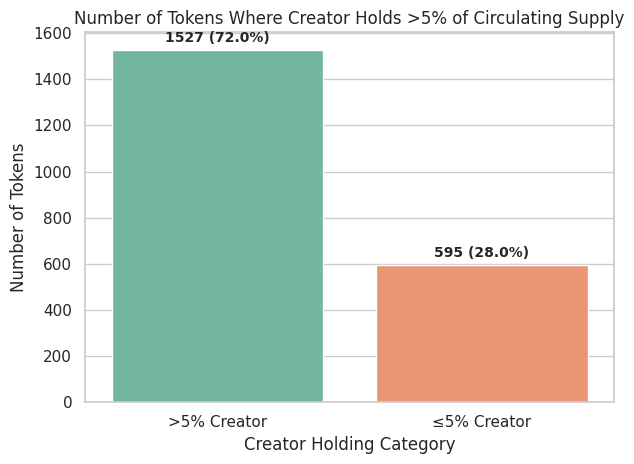

In [5]:
# Load data
df_contracts = pd.read_csv('../csv_outputs/master_contract.csv')
df_holders_list = pd.read_csv('../csv_outputs/master_holders_list.csv')
df_holders = pd.read_csv('../csv_outputs/master_holders.csv')  # has total_circulating_supply

# Merge holder list with contract info (to get creator)
df_merged = df_holders_list.merge(df_contracts[['token_address', 'creator']], on='token_address', how='left')

# Merge with circulating supply
df_merged = df_merged.merge(df_holders[['token_address', 'total_circulating_supply']], on='token_address', how='left')

# Normalize address case
df_merged['holder_address'] = df_merged['holder_address'].str.lower()
df_merged['creator'] = df_merged['creator'].str.lower()

# Filter to only creator rows
df_creator_holdings = df_merged[df_merged['holder_address'] == df_merged['creator']].copy()

# Calculate percent of total supply held by creator
df_creator_holdings['balance'] = pd.to_numeric(df_creator_holdings['balance'], errors='coerce')
df_creator_holdings['total_circulating_supply'] = pd.to_numeric(df_creator_holdings['total_circulating_supply'], errors='coerce')

# Clean bad data
df_creator_holdings = df_creator_holdings.dropna(subset=['balance', 'total_circulating_supply'])
df_creator_holdings = df_creator_holdings[df_creator_holdings['total_circulating_supply'] > 0]

# Calculate creator percentage
df_creator_holdings['creator_percent'] = (df_creator_holdings['balance'] / df_creator_holdings['total_circulating_supply']) * 100

# Determine which tokens exceed 5%
tokens_over_5 = df_creator_holdings[df_creator_holdings['creator_percent'] > 5]['token_address'].nunique()
total_tokens = df_contracts['token_address'].nunique()
tokens_5_or_less = total_tokens - tokens_over_5

# Prepare plot data
plot_df = pd.DataFrame({
    'Creator Category': ['>5% Creator', '≤5% Creator'],
    'Token Count': [tokens_over_5, tokens_5_or_less]
})

# Calculate percentages for labels
plot_df['Percentage'] = (plot_df['Token Count'] / total_tokens) * 100

# Plot
sns.set(style="whitegrid")
ax = sns.barplot(data=plot_df, x='Creator Category', y='Token Count', palette='Set2')

# Annotate each bar with value and percentage
for i, row in plot_df.iterrows():
    count = row['Token Count']
    percent = row['Percentage']
    ax.text(i, count + (total_tokens * 0.01), f'{count} ({percent:.1f}%)', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Number of Tokens Where Creator Holds >5% of Circulating Supply")
plt.xlabel("Creator Holding Category")
plt.ylabel("Number of Tokens")
plt.tight_layout()
plt.show()


/tmp/ipykernel_744418/2748027614.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x='Holder Category', y='Token Count', palette='coolwarm')


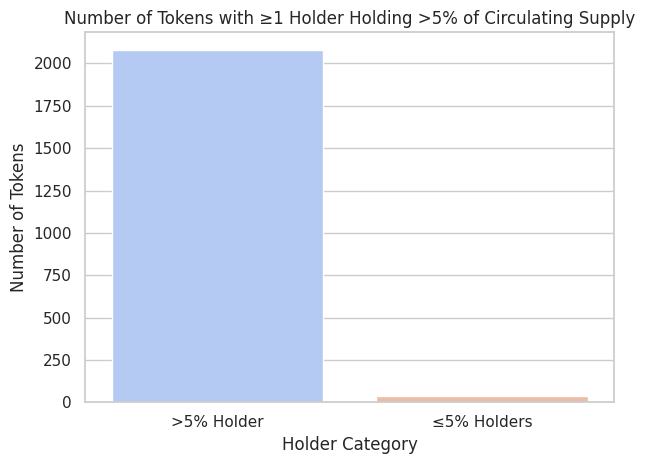

In [6]:
# Load data
df_contracts = pd.read_csv('../csv_outputs/master_contract.csv')  # has token_address, owner
df_holders_list = pd.read_csv('../csv_outputs/master_holders_list.csv')  # has token_address, holder_address, balance
df_holders = pd.read_csv('../csv_outputs/master_holders.csv')  # has token_address, total_circulating_supply

# Merge holders with total circulating supply
df_all = df_holders_list.merge(df_holders[['token_address', 'total_circulating_supply']], on='token_address', how='left')

# Convert to lowercase to standardize addresses
df_all['holder_address'] = df_all['holder_address'].str.lower()

# Convert balance and supply to numeric
df_all['balance'] = pd.to_numeric(df_all['balance'], errors='coerce')
df_all['total_circulating_supply'] = pd.to_numeric(df_all['total_circulating_supply'], errors='coerce')

# Drop rows with invalid or zero supply
df_all = df_all.dropna(subset=['balance', 'total_circulating_supply'])
df_all = df_all[df_all['total_circulating_supply'] > 0]

# Calculate holder's percent of supply
df_all['holder_percent'] = (df_all['balance'] / df_all['total_circulating_supply']) * 100

# Count unique tokens with at least one holder over 5%
tokens_with_holder_over_5 = df_all[df_all['holder_percent'] > 5]['token_address'].nunique()
total_tokens = df_all['token_address'].nunique()

# Prepare data for plotting
plot_df = pd.DataFrame({
    'Holder Category': ['>5% Holder', '≤5% Holders'],
    'Token Count': [tokens_with_holder_over_5, total_tokens - tokens_with_holder_over_5]
})

# Plot
sns.set(style="whitegrid")
sns.barplot(data=plot_df, x='Holder Category', y='Token Count', palette='coolwarm')
plt.title("Number of Tokens with ≥1 Holder Holding >5% of Circulating Supply")
plt.xlabel("Holder Category")
plt.ylabel("Number of Tokens")
plt.tight_layout()
plt.show()

## Top 10 holder % distribution compared to total and circulating supply

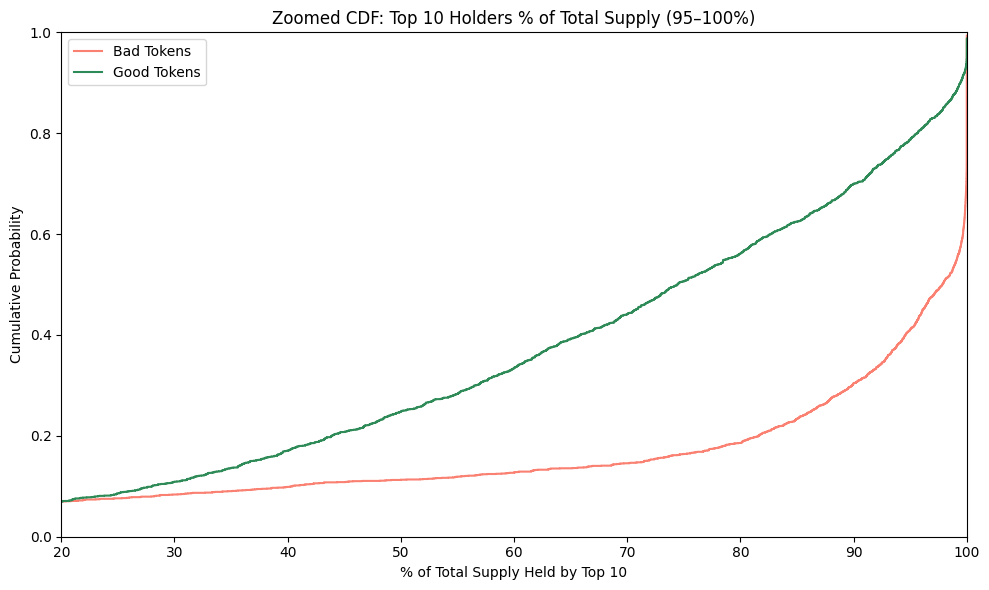

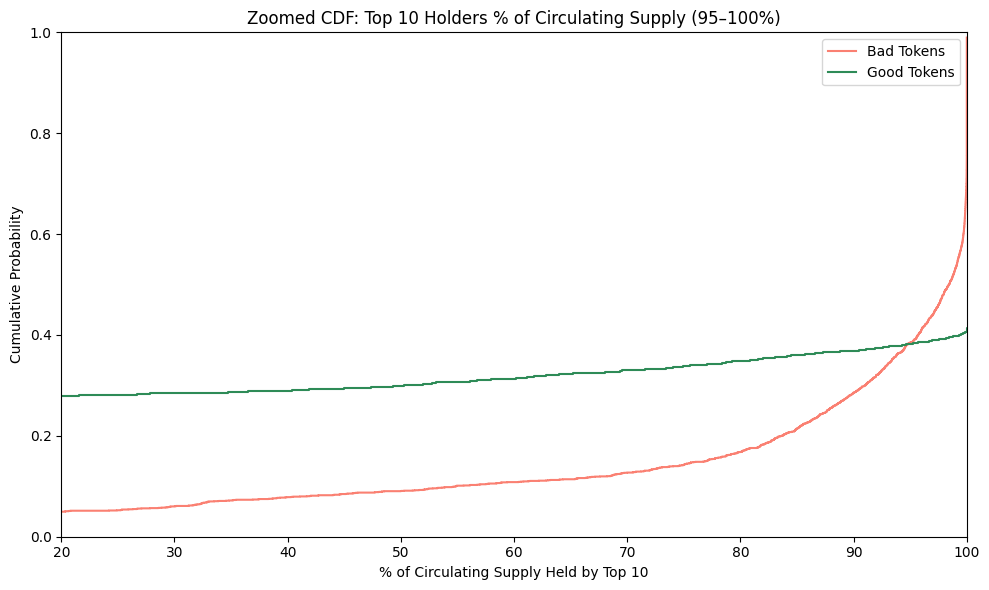

In [28]:
# Load data
df_holders_bad = pd.read_csv('../csv_outputs/bad_tokens/master_holders.csv')
df_holders_good = pd.read_csv('../csv_outputs/good_tokens/master_holders.csv')

# Convert relevant columns to numeric and drop NaNs
bad_total_pct = pd.to_numeric(df_holders_bad['top10_percentage_of_total_supply'], errors='coerce').dropna()
good_total_pct = pd.to_numeric(df_holders_good['top10_percentage_of_total_supply'], errors='coerce').dropna()

bad_circ_pct = pd.to_numeric(df_holders_bad['top10_percentage_of_circulating_supply'], errors='coerce').dropna()
good_circ_pct = pd.to_numeric(df_holders_good['top10_percentage_of_circulating_supply'], errors='coerce').dropna()

plt.figure(figsize=(10, 6))
sns.ecdfplot(bad_total_pct, label='Bad Tokens', color='salmon')
sns.ecdfplot(good_total_pct, label='Good Tokens', color='seagreen')

plt.title('Zoomed CDF: Top 10 Holders % of Total Supply (95–100%)')
plt.xlabel('% of Total Supply Held by Top 10')
plt.ylabel('Cumulative Probability')
plt.xlim(20, 100)
plt.legend()
plt.tight_layout()
plt.show()


# Plot CDFs: Top 10 holders % of circulating supply
plt.figure(figsize=(10, 6))
sns.ecdfplot(bad_circ_pct, label='Bad Tokens', color='salmon')
sns.ecdfplot(good_circ_pct, label='Good Tokens', color='seagreen')
plt.title('Zoomed CDF: Top 10 Holders % of Circulating Supply (95–100%)')
plt.xlabel('% of Circulating Supply Held by Top 10')
plt.ylabel('Cumulative Probability')
plt.xlim(20, 100)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
df_holders_good = pd.read_csv('../csv_outputs/good_tokens/master_holders.csv')
df_holders_good['total_top_10_balance']

0            436371089577191393236992
1         182339813094948419017900032
2       67182102951423733181079093248
3         995231936343434193461575680
4         604046262491037042116395008
                    ...              
1995                55093581860199403
1996      123859277158526589572481024
1997           5588457669833124806656
1998       35970979530533645464895488
1999                     843532440927
Name: total_top_10_balance, Length: 2000, dtype: object

## Top 10 token holders possess < 70% of circulating token supply (no locking addresses)

/tmp/ipykernel_744418/1139852702.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_holders, x='top_10_less_than_70_percent_of_total', palette='Set2')


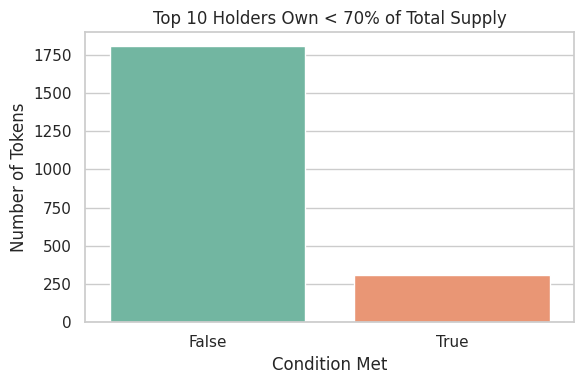

/tmp/ipykernel_744418/1139852702.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_holders, x='top_10_less_than_70_percent_of_circulating', palette='Set3')


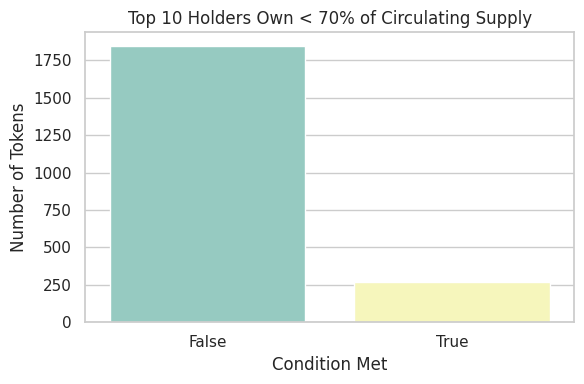

In [9]:
# Plot 1: top_10_less_than_70_percent_of_total
plt.figure(figsize=(6, 4))
sns.countplot(data=df_holders, x='top_10_less_than_70_percent_of_total', palette='Set2')
plt.title('Top 10 Holders Own < 70% of Total Supply')
plt.xlabel('Condition Met')
plt.ylabel('Number of Tokens')
plt.xticks([0, 1], ['False', 'True'])
plt.tight_layout()
plt.show()

# Plot 2: top_10_less_than_70_percent_of_circulating
plt.figure(figsize=(6, 4))
sns.countplot(data=df_holders, x='top_10_less_than_70_percent_of_circulating', palette='Set3')
plt.title('Top 10 Holders Own < 70% of Circulating Supply')
plt.xlabel('Condition Met')
plt.ylabel('Number of Tokens')
plt.xticks([0, 1], ['False', 'True'])
plt.tight_layout()
plt.show()

In [10]:
df_holders_list

,token_address,chain,token_name,holder_address,balance,percentage_of_total_supply,percentage_of_circulating_supply
0,0x0a4DC3AC9426e1c85db6b618de48a2bBdd596C4e,bsc,Demon,0x23c9bb2a7564e78aebe75f2fa1557f510e285c74,1.046656e+16,0.000000,0.0000
1,0x0a4DC3AC9426e1c85db6b618de48a2bBdd596C4e,bsc,Demon,0x763683e2524a303d3c173a97d9d9e98b664da5b7,1.220628e+18,0.000100,0.0001
2,0x0a4DC3AC9426e1c85db6b618de48a2bBdd596C4e,bsc,Demon,0xac95a5e29b5c4b4299d718c45039bede5c605eb7,3.773732e+15,0.000000,0.0000
3,0x0a4DC3AC9426e1c85db6b618de48a2bBdd596C4e,bsc,Demon,0x823f5a212b795067a132f42cb56b027b93799de3,6.561999e+16,0.000000,0.0000
4,0x0a4DC3AC9426e1c85db6b618de48a2bBdd596C4e,bsc,Demon,0x5b705164a2e3579dd7e2c1a0ac8332ae53ebdf57,3.342430e+15,0.000000,0.0000
...,...,...,...,...,...,...,...
132378,0xFFEB21c405b2c1F484b3C8Ac0f608D9a7f86c5b2,bsc,SluttyDoge,0xe471bc36cacb1ed49ad08d229c13d9ea9330443d,2.882829e+13,0.000000,0.0000
132379,0xFFEB21c405b2c1F484b3C8Ac0f608D9a7f86c5b2,bsc,SluttyDoge,0xacf4eab9b901fd87e9d935d6c81347ddf40825e7,1.418853e+12,0.000000,0.0000
132380,0xFFEB21c405b2c1F484b3C8Ac0f608D9a7f86c5b2,bsc,SluttyDoge,0x2156182ab03684a6042bf6e4dcbbc79ac5bec8f2,7.600000e+08,0.000000,0.0000
132381,0xFFEB21c405b2c1F484b3C8Ac0f608D9a7f86c5b2,bsc,SluttyDoge,0xfbf7aa38eaf0c907b74bd310a46892aadd549277,5.153528e+08,0.000000,0.0000


## All other holders possess < 5% of circulating token supply (Not a single one has > 5%)

/tmp/ipykernel_744418/1930208331.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, x='Holder Concentration', y='Token Count', palette='Set2')


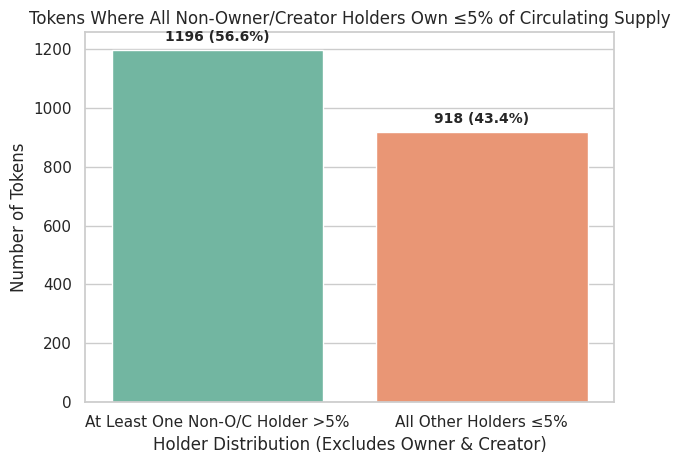

In [11]:
# Analyze tokens where no single non-owner/creator holder owns >5% of circulating supply

# Normalize address case
df_holders_list['holder_address'] = df_holders_list['holder_address'].str.lower()
df_contracts['owner'] = df_contracts['owner'].str.lower()
df_contracts['creator'] = df_contracts['creator'].str.lower()

# Merge holders list with owner and creator info
df_holders_enriched = df_holders_list.merge(
    df_contracts[['token_address', 'owner', 'creator']], on='token_address', how='left'
)

# Exclude owner and creator addresses
df_filtered = df_holders_enriched[
    (df_holders_enriched['holder_address'] != df_holders_enriched['owner']) &
    (df_holders_enriched['holder_address'] != df_holders_enriched['creator'])
].copy()

# Convert to numeric if necessary
df_filtered['percentage_of_circulating_supply'] = pd.to_numeric(
    df_filtered['percentage_of_circulating_supply'], errors='coerce'
)

# Drop any remaining NaNs just in case
df_filtered = df_filtered.dropna(subset=['percentage_of_circulating_supply'])

# Group by token and find max holder share (excluding owner/creator)
token_check = df_filtered.groupby('token_address')['percentage_of_circulating_supply'].max().reset_index()

# Classify tokens
token_check['Holder Concentration'] = token_check['percentage_of_circulating_supply'].apply(
    lambda x: 'All Other Holders ≤5%' if x <= 5 else 'At Least One Non-O/C Holder >5%'
)

# Count how many tokens fall in each category
plot_df = token_check['Holder Concentration'].value_counts().reset_index()
plot_df.columns = ['Holder Concentration', 'Token Count']

# Calculate total tokens for percentage labels
total_tokens = token_check['token_address'].nunique()
plot_df['Percentage'] = (plot_df['Token Count'] / total_tokens) * 100

# Plot
sns.set(style="whitegrid")
ax = sns.barplot(data=plot_df, x='Holder Concentration', y='Token Count', palette='Set2')

# Annotate each bar with count and percentage
for i, row in plot_df.iterrows():
    count = row['Token Count']
    percent = row['Percentage']
    ax.text(i, count + (total_tokens * 0.01), f'{count} ({percent:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Tokens Where All Non-Owner/Creator Holders Own ≤5% of Circulating Supply")
plt.xlabel("Holder Distribution (Excludes Owner & Creator)")
plt.ylabel("Number of Tokens")
plt.tight_layout()
plt.show()
